# Task Space Inverse Dynamics

In this notebook is presented a simple use of the TSID framework on a humanoid robot, Pyrene.

### Notations and Definitions

The robot system has a state $x$ and we denote the control inputs as $u$. <br>
The model depends on both the __robot__ and **task**. In our case the model of the robot actuators is torque based because the robot's motors provide torque sources. Therefore the control input $u$ are motor torques $\tau$. <br>
With the robot configuration $q$ and its velocity $\dot{q}$ we have the robot state $x$:

$$ x \triangleq (q, \dot{q}) $$

### Generic Feature

A feature $s$, can be an end-effector pose (such as a gripper), the robot center-of-mass, a visual feature position inside an image.
We assume that a feature can be computed from the robot motor configuration vector $q$ to a set called $FS$ for Feature Space:

$$s = f_{task}(q)$$

It is also assumed that $f_{task}$ is $\mathcal{C}^1$ then:
$$J = \displaystyle \frac{\partial f_{task}}{\partial q}$$

When a desired feature $s^*$ is given, a task is defined as:

$$
  e: \mathcal{C} \times \mathbf{R} \rightarrow \mathbf{R}^m
  e = s \ominus s^*
$$

where $\ominus$ is the difference operator in the feature space.

It is also required to define the dynamics of the task.
Usually, when the robot is controlled in velocity, the dynamics is constrained to :

$$  \dot{e} = - \lambda e $$


When the robot is controlled in acceleration, the dynamics is the following:

$$
  \ddot{e} = K_P ( s \ominus s^*) + K_D ( \dot{s} - \dot{s}^*) + K_I \displaystyle \int_{j=0}^{j=k} ( s(j) \ominus s^*(j))dj 
$$

with $K_P$ the error gain, $K_D$ the derivative of the error gain, and $K_I$ the integral gain.

We can also see that:

$$  \dot{e} = \dot{s} - \dot{s}^*
     = J \dot{q} - \dot{s}^*$$

which also gives:

$$\ddot{e} = J \ddot{q} + \dot{J} \dot{q} - \ddot{s}^* $$


### Torque Control of Under-Actuated Systems

A humanoid robot is __under actuated__, its number of actuators is less than its number of degrees of freedom (DoFs). <br>
We denotes $n_{va}$ the number of actuators and $n_v$ the number of DoFs:

$$ n_{va} < n_v $$


Assume elements of $q$ are ordered, $q \triangleq (q_u, q_a)$, where:
-  $q_u \in \mathbb{R}^{n_{qu}} $ are the passive (unactuated) joints
-  $q_a \in \mathbb{R}^{n_{qa}} $ are the actuated joints

Similarly, $\dot{q} \triangleq (\dot{q}_u, \dot{q}_a)$, where $\dot{q}_u \in \mathbb{R}^{n_{vu}}$ and $\dot{q}_a \in \mathbb{R}^{n_{va}}$.

$ S \triangleq [\ 0_{n_{va} \ \times \ n_{vu}} \ \ I_{n_{va}}] $ is a selection matrix associated to the actuated joints:
$$ \dot{q}_a = S \ \dot{q} $$


The dynamic of an under-actuated mechanical system is:

$$ M(q) \ \ddot{q} \ + \ h(q, \dot{q}) \ = \ S^T \tau \ + \ J(q)^T f $$

where $M(q) \in \mathbb{R}^{n_v × n_v}$ is the mass matrix, $h(q,v_q) \in \mathbb{R}^{n_v}$ are the bias forces, $\tau \in \mathbb{R}^{n_{va}}$ are the joint torques, $f \in \mathbb{R}^{n_f}$ are the contact forces, and $J(q) \in \mathbb{R}^{n_f×n_v}$ is the contact Jacobian.

This dynamic is often decomposed into unactuated and actuated parts:

\begin{array}{r c r c l}
      M_u(q) \ \ddot{q}  & + & h_u(q, \dot{q}) & = & J_u(q)^T f \\
      M_a(q) \ \ddot{q}  & + & h_a(q, \dot{q}) & = & \tau \ + \ J_a(q)^T f 
\end{array}

Where

\begin{array}{r c l}
   M & = & \begin{bmatrix}
   M_u \\
   M_a
\end{bmatrix}  \\
   h & = & \begin{bmatrix}
   h_u \\
   h_a
\end{bmatrix}  \\
  J & = & [J_u \ \ J_a]
\end{array}
   

### QP Optimisation problem with acceleration and torque 

The  transcription  of  the  motion  reference  from  the  task space  to  the  whole-body  control  is  naturally  written  as  a quadratic  program  (QP).  A  QP  is  composed  of  two layers,  namely  the  constraint  and  the  cost.  It  can  be  seen  as a  hierarchy  of  two  levels,  the  constraint  having  priority  over the  cost. Inequalities can also be taken into account  directly,  as  constraints,  or  in  the  cost  function.

Let us simplify the motion equation based on the rigid body dynamics when there is no contacts: 

$$M \ddot{q} + h = S\tau $$

If we have a task $e$ regulating a feature $s$, the dynamic of the task can be imposed, for instance as an exponential decay:

$$	e  =  s - s^*$$

$$  \dot{e}  =  - \lambda \, e $$

We can then introduce a slack  variable $w$ (an implicit optimization variable) to  add  some  freedom  to the solver if no solution can be found: 

$$\dot{e} - \lambda \, (s - s^*)  =  w $$

A simple formulation of the QP problem can then be expressed as:

$$   \underset{\ddot{q},\tau}{\min} \quad  \| w \|^2 \\
	\textrm{s.t.} \quad  M \ddot{q} + h = S\tau $$

If the system is in contact with environment, its dynamic must account for contact forces $f_{ext}$. If contacts are soft, measured/estimated contact forces $\hat{f}_{ext}$ can be easily included:

$$	\underset{\ddot{q},\tau}{\min} \quad \| w \|^2 \\
	\textrm{s.t.} \quad M \ddot{q} + h = S\tau + J_c^T \hat{f}_{ext} $$


But if contacts are rigid, they constrain the motion. They are usually modelled as nonlinear functions, which are differentiated twice:

$$	c(q)  =  0  \, \Leftrightarrow  \text{Contact point do not move}$$

$$	J_c^T \, \dot{q}  = 0  \, \Leftrightarrow  \text{Contact point velocities are null}$$

$$	J_c^T \, \ddot{q} + \dot{J_c} \, \dot{q}  =  0  \, \Leftrightarrow  \text{Contact point accelerations are null}$$


This leads to the following optimization problem:

$$	\underset{\ddot{q},\tau}{\min} \quad  \| w \|^2 \\
	\textrm{s.t.} \quad \Bigg[ 
	\begin{array}{lll}
		J_c & 0 & 0 \\ 
		M  & -J_c^T & -S^T
	\end{array}
	\Bigg] \, \Bigg[\begin{array}{l}
                    \ddot{q} \\
                    f \\
                    \tau
                    \end{array}
               \Bigg] \, = \, \Bigg[\begin{array}{l}
                                    - \dot{J_c} \, \dot{q} \\
                                    -h 
                                    \end{array}
                              \Bigg]$$

The main benefit of QP solver is that they can handle inequality-constraints. It is mainly used to defined boundaries of the system such as torque, velocity or joint limits; and also friction cones for the contacts.



### Weighted Sum

Complex robots are typically redundant with respect to the main task they must perform, this redundancy can be used to execute secondary tasks. This multi-objective optimization can be achieved by setting respective weights between the tasks (strategy used in TSID), or by imposing a strict hierarchy between them (cascade of QP or HQP).

Assume robot must perform N tasks, each defined by a task function and its optimization variable $w_i$:

$$	g_i = \| w_i \|^2 $$

The easiest strategy is to sum all functions using user-defined weights $\lambda_i$:

$$	\underset{\ddot{q},\tau}{\min} \quad \displaystyle \sum_{i=0}^N{\lambda_i \, g_i} \\
	\textrm{s.t.} \quad \Bigg[ 
	\begin{array}{lll}
		J_c & 0 & 0 \\ 
		M  & -J_c^T & -S^T
	\end{array}
	\Bigg] \, \Bigg[\begin{array}{l}
                    \ddot{q} \\
                    f \\
                    \tau
                    \end{array}
               \Bigg] \, = \, \Bigg[\begin{array}{l}
                                    - \dot{J_c} \, \dot{q} \\
                                    -h 
                                    \end{array}
                              \Bigg]$$

This problem remains standard computationally-efficient (compared to Least Square Programming). But, finding proper weights is hard and too extreme weights can lead to numerical issues. 

# An example: CoM Sinusoidal trajectory on the robot TALOS

The goal of this exercise is to create a set of tasks allowing the control of the robot CoM position.

As a second approach, the tracking of a sinusoidal trajectory by the CoM is presented.

In the following is described the process to create, initialise and solve the HQP problem defined by the tasks to control the CoM of the robot Pyrene.

In [1]:
import sys
def enable_global_distpackages():
    sys.path.append('/usr/lib/python2.7/dist-packages')
    sys.path.append('/usr/local/lib/python2.7/dist-packages')

In [1]:
# Python import needed by the exercise

import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib as matlib
from numpy import nan
from numpy.linalg import norm as norm
import os
import time as tmp

# import the library TSID for the Whole-Body Controller
import tsid
# import the pinocchio library for the mathematical methods (Lie algebra) and multi-body dynamics computations.
import pinocchio as pin

enable_global_distpackages()
sys.path.append('..')

# import graphical tools
import plot_utils as plut
import gepetto.corbaserver

In [2]:
# Definition of the tasks gains and weights and the foot geometry (for contact task)

lxp = 0.1                           # foot length in positive x direction
lxn = 0.11                          # foot length in negative x direction
lyp = 0.069                         # foot length in positive y direction
lyn = 0.069                         # foot length in negative y direction
lz = 0.107                          # foot sole height with respect to ankle joint
mu = 0.3                            # friction coefficient
fMin = 1.0                          # minimum normal force
fMax = 1000.0                       # maximum normal force

rf_frame_name = "leg_right_6_joint"          # right foot joint name
lf_frame_name = "leg_left_6_joint"           # left foot joint name
contactNormal = np.matrix([0., 0., 1.]).T    # direction of the normal to the contact surface

w_com = 1.0                       # weight of center of mass task
w_posture = 0.1                   # weight of joint posture task
w_forceRef = 1e-3                 # weight of force regularization task
w_waist = 1.0                     # weight of waist task

kp_contact = 30.0                 # proportional gain of contact constraint
kp_com = 20.0                     # proportional gain of center of mass task               
kp_waist = 500.0                  # proportional gain of waist task

kp_posture = np.matrix(                                   # proportional gain of joint posture task
    [ 10. ,  5.  , 5. , 1. ,  1. ,  10.,                  #lleg  #low gain on axis along y and knee
    10. ,  5.  , 5. , 1. ,  1. ,  10.,                    #rleg
    500. , 500.  ,                                        #chest
    50.,   10.  , 10.,  10.,    10. ,  10. , 10. ,  10. , #larm
    50.,   10.  , 10., 10.,    10. ,  10. ,  10. ,  10. , #rarm
    100.,  100.]                                          #head
).T 

dt = 0.001                        # controller time step
PRINT_N = 500                     # print every PRINT_N time steps
DISPLAY_N = 20                    # update robot configuration in viwewer every DISPLAY_N time steps
N_SIMULATION = 10000              # number of time steps simulated

In [3]:
# Set the path where the urdf file of the robot is registered
path = "/opt/openrobots/share"
urdf = path + '/talos_data/urdf/talos_reduced.urdf'
vector = pin.StdVec_StdString()
vector.extend(item for item in path)
# Create the robot wrapper from the urdf, it will give the model of the robot and its data
robot = tsid.RobotWrapper(urdf, vector, pin.JointModelFreeFlyer(), False)
srdf = path + '/talos_data/srdf/talos.srdf'

In [4]:
# Creation of the robot wrapper for gepetto viewer (graphical interface)
robot_display = pin.RobotWrapper.BuildFromURDF(urdf, [path, ], pin.JointModelFreeFlyer())
tmp.sleep(1)
cl = gepetto.corbaserver.Client()
gui = cl.gui
robot_display.initViewer(loadModel=True)

In [5]:
# Take the model of the robot and load its reference configurations
model = robot.model()
pin.loadReferenceConfigurations(model, srdf, False)
# Set the current configuration q to the robot configuration half_sitting
q = model.referenceConfigurations['half_sitting']
# Set the current velocity to zero
v = np.matrix(np.zeros(robot.nv)).T

In [6]:
# Display the robot in Gepetto Viewer in the configuration q = halfSitting
robot_display.displayCollisions(False)
robot_display.displayVisuals(True)
robot_display.display(q)

In [7]:
# Check that the frames of the feet exist. 
assert model.existFrame(rf_frame_name)
assert model.existFrame(lf_frame_name)

In [8]:
t = 0.0 # time

# Creation of the inverse dynamics HQP problem using 
# the robot accelerations (base + joints) and the contact forces as decision variables
# As presented in the cell on QP optimisation
invdyn = tsid.InverseDynamicsFormulationAccForce("tsid", robot, False)
# Compute the problem data with a solver based on EiQuadProg: a modified version of uQuadProg++ working with Eigen
invdyn.computeProblemData(t, q, v)
# Get the data -> initial data
data = invdyn.data()


## Tasks Definitions 

A **Task** is a control objective for the robot, which is used at each control cycle to generate a **Constraint**. 
Note that constraints are purely mathematical objects that are independent of the concept of robot, while Tasks are instead robot-related objects.

A **Constraint** is a linear equality or inequality.

A QP is composed of two layers, namely the constraint and the cost. It can be seen as a hierarchy of two levels, the constraints having priority over the cost. 
In TSID the HQP is defined as a collection of constraints with different priority levels and weights.

There are three kind of constraints defined in TSID:

- Equalities, represented by matrix $A$ and vector $a$:    
  $$ Ax = a $$
    
- Inequalities, represented by matrix $A$ and vectors $lb$ and $ub$:     
  $$ lb ≤ Ax ≤ ub $$

- Bounds, represented by vectors $lb$ and $ub$:    
  $$ lb ≤ x ≤ ub $$
  
There are three kind of Task in TSID:

- **TaskMotion**: computes a constraint that is a linear function of the robot accelerations
- **TaskContactForce**: computes a constraint that is a linear function of the contact forces
- **TaskActuation**: computes a constraint that is a linear function of the joint torques

Tasks can compute either equality constraints, or bounds, or inequality constraints. 

Examples of **TaskMotion**:

- **TaskComEquality**: computes an equality constraint to specify a desired acceleration of the center of mass (CoM) of the robot. 
- **TaskJointPosture**: computes an equality constraint to specify the desired joint accelerations.
- **TaskSE3Equality**: computes an equality constraint to specify the desired acceleration for a frame attached to one of the links of the robot. 
- **TaskJointBounds**: computes a bounds constraint to specify the joint acceleration bounds in order to satisfy the joint position/velocity/acceleration limits.

In this exercise, for the sinusoidal movement of the CoM, we need 3 task motions:

 - **TaskComEquality** as **constraint of the control** (priority level = 0) to make the CoM follow a sinusoidal trajectory. It is the most important task so has a weight of 1 (in constraint scope).
 - **TaskSE3Equality** in the **cost function** (priority level = 1) for the waist of the robot, to maintain its orientation (with a reference trajectory). It is an important task so has a weight of 1 (in cost function scope).
 - **TaskJointPosture** in the **cost function** (priority level = 1) for the posture of the robot, to maintain it to half-sitting as much as possible (with a reference trajectory). It is the less important task so has a weight of 0.1 (in cost function scope).

In [9]:
# COM Task
comTask = tsid.TaskComEquality("task-com", robot)
comTask.setKp(kp_com * matlib.ones(3).T) # Proportional gain defined before = 20
comTask.setKd(2.0 * np.sqrt(kp_com) * matlib.ones(3).T) # Derivative gain = 2 * sqrt(20)
# Add the task to the HQP with weight = 1.0, priority level = 0 (as real constraint) and a transition duration = 0.0
invdyn.addMotionTask(comTask, w_com, 0, 0.0)


# WAIST Task
waistTask = tsid.TaskSE3Equality("keepWaist", robot, 'root_joint') # waist -> root_joint
waistTask.setKp(kp_waist * matlib.ones(6).T) # Proportional gain defined before = 500
waistTask.setKd(2.0 * np.sqrt(kp_waist) * matlib.ones(6).T) # Derivative gain = 2 * sqrt(500)

# Add a Mask to the task which will select the vector dimensions on which the task will act.
# In this case the waist configuration is a vector 6d (position and orientation -> SE3)
# Here we set a mask = [0 0 0 1 1 1] so the task on the waist will act on the orientation of the robot
mask = matlib.ones(6).T
mask[:3] = 0.
waistTask.setMask(mask)
# Add the task to the HQP with weight = 1.0, priority level = 1 (in the cost function) and a transition duration = 0.0
invdyn.addMotionTask(waistTask, w_waist, 1, 0.0)


# POSTURE Task
postureTask = tsid.TaskJointPosture("task-posture", robot)
postureTask.setKp(kp_posture) # Proportional gain defined before (different for each joints)
postureTask.setKd(2.0 * kp_posture) # Derivative gain = 2 * kp
# Add the task to the HQP with weight = 0.1, priority level = 1 (in the cost function) and a transition duration = 0.0
invdyn.addMotionTask(postureTask, w_posture, 1, 0.0)

True

## Rigid Contacts Definitions 

A **Rigid Contact** is a description of a rigid contact between a body of the robot and another object. 
The main difference between a task and a rigid contact is that a rigid contact is associated to reaction forces, while a task is not. 

This class allows to use different representations for the motion space and the force space:

- Motion Task
    - Represents motion constraint (equality) caused by rigid contact
    - $ J_c \, \ddot{q} \, = \, - \dot{J_c} \, \dot{q} \, - \, K_p \ e - \, K_d \, \dot{e}$
    
    
- Force Task
    - Represents inequality constraints acting on contact forces
    - e.g., friction cone constraints : $A \, f \,  ≤ \, a$
    
    
- Force Regularization Task
    - Regularizes contact forces
    - e.g., keep them close to friction cone center
    
    
- Force-Generator matrix $T$
    - Maps force variables to motion constraint representation
    - Dynamic: $ M \ \ddot{q} \ + \ h \ = \ S^T \tau \ + \ J^T T f $
    - Motion constraint : $ J_c \, \ddot{q} \, = \, - \dot{J_c} \, \dot{q}$
    - Friction cones: $A \, f \,  ≤ \, a$

### Contact 6d

In case of a unilateral plane contact (with polygonal shape), the motion constraint is 6d, because the body in contact cannot move in any direction. 
##### PROBLEM

Minimal force representation would be 6d (3d force + 3d moment):
- It is hard to write friction constraints with 6d force representation (especially for non-rectangular contact shapes)
- A solution would be to represent the reaction force as collection of 3d forces applied at vertices of contact surface (writting friction constraints is then easy)
    - But it leads to redundant representation, e.g., 4-vertex surface → 12 variables
    - The redundancy is an issue for motion constraint if HQP solver does not handle redundant constraints (as eiQuadProg). 

##### SOLUTION

- Use 6d representation for motion constraint $ J_c \, \ddot{q} \, = \, - \dot{J_c} \, \dot{q} \, \in \mathbf{R}^6$
- But use 12d representation for force variable $f \in \mathbf{R}^{12}$
- A force-generator matrix $T \in \mathbf{R}^{6 \times 12}$ defines the mapping between the two representations: 
    $\tau_{c} \, = J_c^T \, T \, f$

In this exercise, we need two Rigid Contacts, one for each foot as **Contact6d**.

The Rigid Contacts are always defined as **constraint of the control** (priority level = 0) to maintain the robot in contact. However it is less important than the CoM task, thus, has a weight of 1e-3 (in constraint scope).

In [10]:
# CONTACTS 6D
# Definition of the foot geometry with respect to the ankle joints (which are the ones controlled)
contact_Point = np.matrix(np.ones((3,4)) * lz)
contact_Point[0, :] = [-lxn, -lxn, lxp, lxp]
contact_Point[1, :] = [-lyn, lyp, -lyn, lyp]

# The feet are the only bodies in contact in this experiment and their geometry define the plane of contact
# between the robot and the environement -> it is a Contact6D

# To define a contact6D :
# We need the surface of contact (contact_Point), the normal vector of contact (contactNormal along the z-axis)
# the friction parameter with the ground (mu = 0.3), the normal force bounds (fMin =1.0, fMax=1000.0) 

# Right Foot 
contactRF = tsid.Contact6d("contact_rfoot", robot, rf_frame_name, contact_Point, contactNormal, mu, fMin, fMax)
contactRF.setKp(kp_contact * matlib.ones(6).T) # Proportional gain defined before = 30
contactRF.setKd(2.0 * np.sqrt(kp_contact) * matlib.ones(6).T) # Derivative gain = 2 * sqrt(30)
# Reference position of the right ankle -> initial position  
H_rf_ref = robot.position(data, model.getJointId(rf_frame_name))
contactRF.setReference(H_rf_ref)
# Add the contact to the HQP with weight = 0.1, priority level = 1e-3 (as real constraint)
invdyn.addRigidContact(contactRF, w_forceRef)

# Left Foot
contactLF = tsid.Contact6d("contact_lfoot", robot, lf_frame_name, contact_Point, contactNormal, mu, fMin, fMax)
contactLF.setKp(kp_contact * matlib.ones(6).T) # Proportional gain defined before = 30
contactLF.setKd(2.0 * np.sqrt(kp_contact) * matlib.ones(6).T) # Derivative gain = 2 * sqrt(30)
# Reference position of the left ankle -> initial position  
H_lf_ref = robot.position(data, model.getJointId(lf_frame_name))
contactLF.setReference(H_lf_ref)
# Add the contact to the HQP with weight = 0.1, priority level = 1e-3 (as real constraint)
invdyn.addRigidContact(contactLF, w_forceRef)

True

## TSID Trajectory

A **Trajectory** is a multi-dimensional function of time describing the motion of an object and its time derivatives.
For standard use in control, the method *compute_next* is provided, which computes the value of the trajectory at the next time step.

In the example, we need to set 3 trajectories, one for each task. 
These trajectories will give at each time step the desired position, velocity and acceleration of the different tasks (CoM, posture and waist).
In our case, the posture and the waist will be constants, equal to their initial values.
For the CoM however, we will update the trajectory with a sinusoidal signal at each time step.

In [11]:
# Set the reference trajectory of the tasks

com_ref = data.com[0] # Initial value of the CoM
trajCom = tsid.TrajectoryEuclidianConstant("traj_com", com_ref) 
sampleCom = trajCom.computeNext() # Compute the first step of the trajectory from the initial value

q_ref = q[7:] # Initial value of the joints of the robot (in halfSitting position without the freeFlyer (6 first values))
trajPosture = tsid.TrajectoryEuclidianConstant("traj_joint", q_ref)

waist_ref = robot.position(data, model.getJointId('root_joint')) # Initial value of the waist (root_joint)
# Here the waist is defined as a 6d vector (position + orientation) so it is in the SE3 group (Lie group)
# Thus, the trajectory is not Euclidian but remains in the SE3 domain -> TrajectorySE3Constant
trajWaist = tsid.TrajectorySE3Constant("traj_waist", waist_ref)

In [12]:
# Initialisation of the Solver
# Use EiquadprogFast: dynamic matrix sizes (memory allocation performed only when resizing)
solver = tsid.SolverHQuadProgFast("qp solver")
# Resize the solver to fit the number of variables, equality and inequality constraints
solver.resize(invdyn.nVar, invdyn.nEq, invdyn.nIn) 

In [13]:
# Initialisation of the plot variables which will be updated during the simulation loop 
# These variables describe the behavior of the CoM of the robot (reference and real position, velocity and acceleration)
com_pos = np.zeros((3, N_SIMULATION))*nan
com_vel = np.zeros((3, N_SIMULATION))*nan
com_acc = np.zeros((3, N_SIMULATION))*nan

com_pos_ref = np.zeros((3, N_SIMULATION))*nan
com_vel_ref = np.zeros((3, N_SIMULATION))*nan
com_acc_ref = np.zeros((3, N_SIMULATION))*nan
com_acc_des = np.zeros((3, N_SIMULATION))*nan 


In [14]:
# Parameters of the sinusoid

offset     = robot.com(data) # offset of the mesured CoM 
amp        = np.array([0.0, 0.05, 0.0]).T # amplitude function of 0.05 along the y axis 
two_pi_f             = 2*np.pi*np.array([0.0, 0.5, 0.0]).T # 2π function along the y axis with 0.5 amplitude
two_pi_f_amp         = np.multiply(two_pi_f,amp)  # 2π function times amplitude function
two_pi_f_squared_amp = np.multiply(two_pi_f, two_pi_f_amp) # 2π function times squared amplitude function

In [15]:
# Simulation loop
# At each time step compute the next desired positions of the tasks
# Set them as new references for each tasks 

# The CoM trajectory is set with the sinusoid parameters:
# a sinus for the position, a cosinus (derivative of sinus) for the velocity 
# and a -sinus (derivative of cosinus) for the acceleration

# Compute the new problem data (HQP problem update)
# Solve the problem with the solver

# Get the forces and the accelerations computed by the solver
# Update the plot variables of the CoM 
# Print the forces applied at each feet 
# Print the tracking error of the CoM task and the norm of the velocity and acceleration needed to follow the 
# reference trajectory

# Integrate the control (which is in acceleration and is given to the robot in position):
# One simple euler integration from acceleration to velocity
# One integration (velocity to position) with pinocchio to have the freeFlyer updated
# Display the result on the gepetto viewer

for i in range(0, N_SIMULATION):
    time_start = tmp.time()
    
    sampleCom.pos(offset + np.multiply(amp, matlib.sin(two_pi_f*t)))
    sampleCom.vel(np.multiply(two_pi_f_amp, matlib.cos(two_pi_f*t)))
    sampleCom.acc(np.multiply(two_pi_f_squared_amp, -matlib.sin(two_pi_f*t)))
    comTask.setReference(sampleCom)
    
    sampleWaist = trajWaist.computeNext()
    waistTask.setReference(sampleWaist)    
    
    samplePosture = trajPosture.computeNext()
    postureTask.setReference(samplePosture)

    HQPData = invdyn.computeProblemData(t, q, v)
    # if i == 0: HQPData.print_all()

    sol = solver.solve(HQPData)
    if(sol.status!=0):
        print ("QP problem could not be solved! Error code:", sol.status)
        break
    
    tau = invdyn.getActuatorForces(sol)
    dv = invdyn.getAccelerations(sol)
    
    com_pos[:,i] = robot.com(invdyn.data())
    com_vel[:,i] = robot.com_vel(invdyn.data())
    com_acc[:,i] = comTask.getAcceleration(dv)
    com_pos_ref[:,i] = sampleCom.pos()
    com_vel_ref[:,i] = sampleCom.vel()
    com_acc_ref[:,i] = sampleCom.acc()
    com_acc_des[:,i] = comTask.getDesiredAcceleration

    if i%PRINT_N == 0:
        print ("Time %.3f"%(t))
        if invdyn.checkContact(contactRF.name, sol):
            f = invdyn.getContactForce(contactRF.name, sol)
            print ("\tnormal force %s: %.1f"%(contactRF.name.ljust(20,'.'),contactRF.getNormalForce(f)))

        if invdyn.checkContact(contactLF.name, sol):
            f = invdyn.getContactForce(contactLF.name, sol)
            print ("\tnormal force %s: %.1f"%(contactLF.name.ljust(20,'.'),contactLF.getNormalForce(f)))

        print ("\ttracking err %s: %.3f"%(comTask.name.ljust(20,'.'),       norm(comTask.position_error, 2)))
        print ("\t||v||: %.3f\t ||dv||: %.3f"%(norm(v, 2), norm(dv)))

    v_mean = v + 0.5*np.resize(dt*dv, np.shape(v))
    v += np.resize(dt*dv, np.shape(v))
    q = pin.integrate(model, q, dt*v_mean)
    t += dt
    
    if i%DISPLAY_N == 0: robot_display.display(q)

    time_spent = tmp.time() - time_start
    if(time_spent < dt): tmp.sleep(dt-time_spent)

Time 0.000
	normal force contact_rfoot.......: 767.2
	normal force contact_lfoot.......: 118.6
	tracking err task-com............: 0.000
	||v||: 0.000	 ||dv||: 5.903
Time 0.500
	normal force contact_rfoot.......: 55.5
	normal force contact_lfoot.......: 830.0
	tracking err task-com............: 0.008
	||v||: 0.094	 ||dv||: 2.016
Time 1.000
	normal force contact_rfoot.......: 438.0
	normal force contact_lfoot.......: 447.6
	tracking err task-com............: 0.002
	||v||: 0.575	 ||dv||: 0.576
Time 1.500
	normal force contact_rfoot.......: 840.8
	normal force contact_lfoot.......: 44.8
	tracking err task-com............: 0.000
	||v||: 0.021	 ||dv||: 1.927
Time 2.000
	normal force contact_rfoot.......: 434.7
	normal force contact_lfoot.......: 450.9
	tracking err task-com............: 0.000
	||v||: 0.600	 ||dv||: 0.613
Time 2.500
	normal force contact_rfoot.......: 46.4
	normal force contact_lfoot.......: 839.1
	tracking err task-com............: 0.000
	||v||: 0.025	 ||dv||: 1.933
Time 3.

In [16]:
# PLOT the result
time = np.arange(0.0, N_SIMULATION*dt, dt)

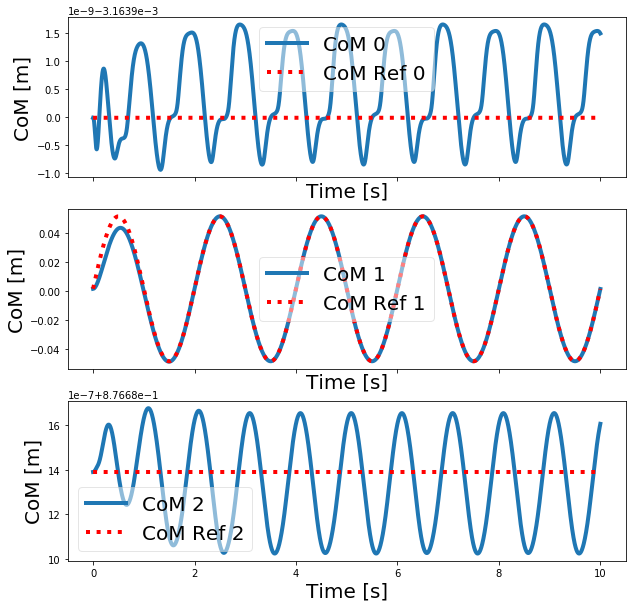

In [17]:
# Position tracking of the CoM along the x,y,z axis

(f, ax) = plut.create_empty_figure(3, 1, figsize=(10,10))
for i in range(3):
    ax[i].plot(time, com_pos[i,:], label='CoM '+str(i))
    ax[i].plot(time, com_pos_ref[i,:], 'r:', label='CoM Ref '+str(i))
    ax[i].set_xlabel('Time [s]')
    ax[i].set_ylabel('CoM [m]')
    leg = ax[i].legend()
    leg.get_frame().set_alpha(0.5)

plt.show()

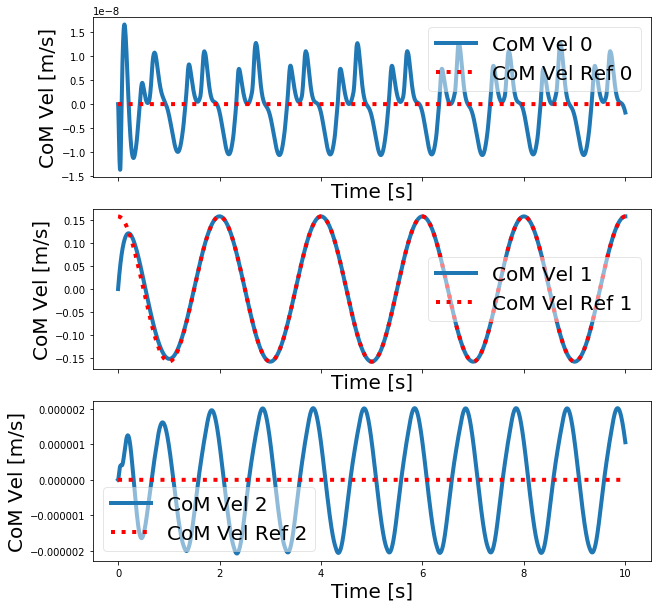

In [18]:
# Velocity tracking of the CoM along the x,y,z axis

(f, ax) = plut.create_empty_figure(3, 1, figsize=(10,10))
for i in range(3):
    ax[i].plot(time, com_vel[i,:], label='CoM Vel '+str(i))
    ax[i].plot(time, com_vel_ref[i,:], 'r:', label='CoM Vel Ref '+str(i))
    ax[i].set_xlabel('Time [s]')
    ax[i].set_ylabel('CoM Vel [m/s]')
    leg = ax[i].legend()
    leg.get_frame().set_alpha(0.5)
    
plt.show()

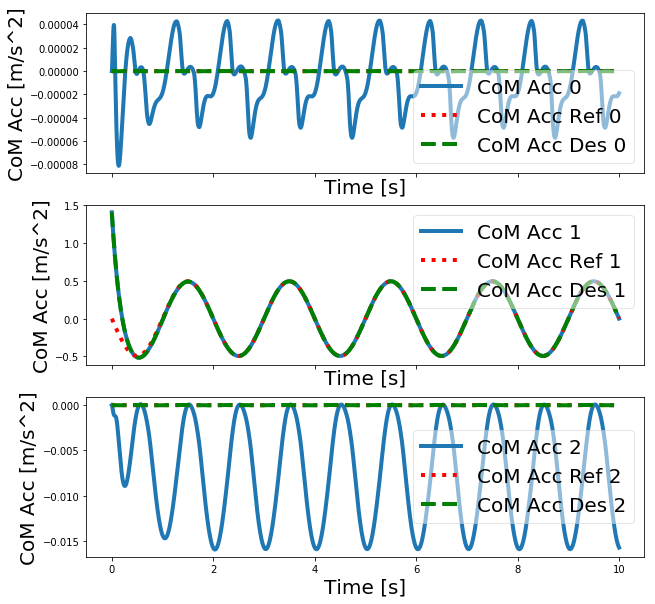

In [19]:
# Acceleration tracking of the CoM along the x,y,z axis

(f, ax) = plut.create_empty_figure(3, 1, figsize=(10,10))
for i in range(3):
    ax[i].plot(time, com_acc[i,:], label='CoM Acc '+str(i))
    ax[i].plot(time, com_acc_ref[i,:], 'r:', label='CoM Acc Ref '+str(i))
    ax[i].plot(time, com_acc_des[i,:], 'g--', label='CoM Acc Des '+str(i))
    ax[i].set_xlabel('Time [s]')
    ax[i].set_ylabel('CoM Acc [m/s^2]')
    leg = ax[i].legend()
    leg.get_frame().set_alpha(0.5)    
    
plt.show()

As expected the robot's CoM follows the sinusoidal trajectory along the y axis (the CoM task defines a sinusoidal movement only on this axis). On the other axis there are small oscillations but the robot remains stable.  